## Driver code comparing output of different atlas / parcellations 

### Steps
- import data csvs from different atlases
- compare performance of machine-learning model (scikit-learn)
- compare performance of statsmodels (ols or logit)

In [1]:
import sys
import numpy as np
import pandas as pd
import itertools

from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from matplotlib_venn import venn2, venn3

import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import time

sys.path.append('../')
from lib.data_handling import *
from lib.data_stats import *

### Data paths

In [2]:
proj_dir = '/home/nikhil/projects/CT_reproduce/code/compare-surf-tools/'
data_dir = proj_dir + 'data/'
results_dir = data_dir + 'results/'
qc_dir =  '/home/nikhil/projects/CT_reproduce/data/QC/'
outlier_dir = data_dir + 'outliers/'
fs60_dir = data_dir + 'fs60_group_stats/'
demograph_file = 'ABIDE_Phenotype.csv'

#fs60 all files
# Thickness
fs60_DKT_lh_thickness_file = 'DKTatlas_thickness_lh.csv' #'lh.aparc.thickness.table.test1' #'aparc_lh_thickness_table.txt' #'lh.aparc.thickness.table.test1'
fs60_DKT_rh_thickness_file = 'DKTatlas_thickness_rh.csv' #'rh.aparc.thickness.table.test1' #'aparc_rh_thickness_table.txt' #'rh.aparc.thickness.table.test1'
fs60_aparc2009_lh_thickness_file = 'lh.aparc.a2009.thickness.table.test1' #74 ROIs per hemi
fs60_aparc2009_rh_thickness_file = 'rh.aparc.a2009.thickness.table.test1'
fs60_glasser_lh_thickness_file = 'lh.glasser.thickness.table.test1' #180 ROIs per hemi
fs60_glasser_rh_thickness_file = 'rh.glasser.thickness.table.test1'

#outlier files
aparc_outlier_file = 'aparc_outlier_data.csv'
destr_outlier_file = 'des_outlier_data.csv'
glass_outlier_file = 'glas_outlier_data.csv'

### Workflow configs

In [28]:
atlas_list = ['DKTatlas','aparc.a2009s','aparc.Glasseratlas'] # DK, Destrieux. Glasser 
covar_list = ['SEX','AGE_AT_SCAN','DX_GROUP','SITE_ID']
qc_list = ['No_QC','manual_lenient','manual_stringent','auto']

### Global Vars

In [4]:
subject_ID_col = 'SubjID'

### Load data

In [31]:
# Demographics and Dx
demograph = pd.read_csv(data_dir + demograph_file)
demograph = demograph.rename(columns={'Subject_ID':subject_ID_col})

# aparc
aparc = 'aparc.DKTatlas'
fs60_DKT_lh_thickness_data = pd.read_csv(fs60_dir + fs60_DKT_lh_thickness_file, delim_whitespace=True)
fs60_DKT_rh_thickness_data = pd.read_csv(fs60_dir + fs60_DKT_rh_thickness_file, delim_whitespace=True)
print('shape of fs60 aparc data l: {}, r: {}'.format(fs60_DKT_lh_thickness_data.shape,fs60_DKT_rh_thickness_data.shape))
fs60_DKT_thickness_data_std = standardize_fs60_data(fs60_DKT_lh_thickness_data, 
                                                      fs60_DKT_rh_thickness_data, subject_ID_col, aparc)
print('shape of stdized fs60 aparc data {}'.format(fs60_DKT_thickness_data_std.shape))


# Destrieux
aparc = 'aparc.a2009s'
fs60_aparc2009_lh_thickness_data = pd.read_csv(fs60_dir + fs60_aparc2009_lh_thickness_file, delim_whitespace=True)
fs60_aparc2009_rh_thickness_data = pd.read_csv(fs60_dir + fs60_aparc2009_rh_thickness_file, delim_whitespace=True)
print('shape of fs60 aparc2009 data l: {}, r: {}'.format(fs60_aparc2009_lh_thickness_data.shape,fs60_aparc2009_rh_thickness_data.shape))
fs60_aparc2009_thickness_data_std = standardize_fs60_data(fs60_aparc2009_lh_thickness_data,
                                                          fs60_aparc2009_rh_thickness_data, subject_ID_col, aparc)
print('shape of stdized fs60 aparc data {}'.format(fs60_aparc2009_thickness_data_std.shape))


# Glasser
aparc = 'aparc.Glasseratlas'
fs60_glasser_lh_thickness_data = pd.read_csv(fs60_dir + fs60_glasser_lh_thickness_file, delim_whitespace=True)
fs60_glasser_rh_thickness_data = pd.read_csv(fs60_dir + fs60_glasser_rh_thickness_file, delim_whitespace=True)
print('shape of fs60 glasser data l: {}, r: {}'.format(fs60_glasser_lh_thickness_data.shape,fs60_glasser_rh_thickness_data.shape))
fs60_glasser_thickness_data_std = standardize_fs60_data(fs60_glasser_lh_thickness_data,
                                                          fs60_glasser_rh_thickness_data, subject_ID_col, aparc)
print('shape of stdized fs60 aparc data {}'.format(fs60_glasser_thickness_data_std.shape))

n_workflow = 1 #Analyzing each atlas separately

shape of fs60 aparc data l: (1047, 33), r: (1047, 34)
shape of left and right merge fs6.0 df (1047, 66)
shape of stdized fs60 aparc data (1047, 66)
shape of fs60 aparc2009 data l: (1047, 76), r: (1047, 76)
shape of left and right merge fs6.0 df (1047, 151)
shape of stdized fs60 aparc data (1047, 151)
shape of fs60 glasser data l: (1047, 182), r: (1047, 182)
shape of left and right merge fs6.0 df (1047, 363)
shape of stdized fs60 aparc data (1047, 363)


### Create master dataframe

In [32]:
data_dict = {'DKT' : fs60_DKT_thickness_data_std,
            'Destrieux' : fs60_aparc2009_thickness_data_std,
            'Glasser' : fs60_glasser_thickness_data_std}

outlier_file_dict = {'DKT' : aparc_outlier_file,
            'Destrieux' : destr_outlier_file,
            'Glasser' : glass_outlier_file}

# Add demographic columns to the master_df
useful_demograph = demograph[[subject_ID_col]+covar_list].copy()

# Replace to (2 with 0 for statsmodels) (1:ASD, 0:Controls)
useful_demograph['DX_GROUP'] = useful_demograph['DX_GROUP'].replace({2:0})
useful_demograph['SEX'] = useful_demograph['SEX']-1

_,useful_demograph[subject_ID_col] = useful_demograph[subject_ID_col].str.rsplit('_', 1).str

### Basic demographic distributions


QC type: No_QC

QC type: manual_lenient

Filtering based on QC_maarten. Number subjects before filtering 1047
Resultant number of subjects 975

QC type: manual_stringent

Filtering based on QC_gleb. Number subjects before filtering 1047
Resultant number of subjects 240

QC type: auto

Filtering based on outlier_all_data. Number subjects before filtering 1047
Resultant number of subjects 961


/home/nikhil/anaconda3/envs/CT_reproduce/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


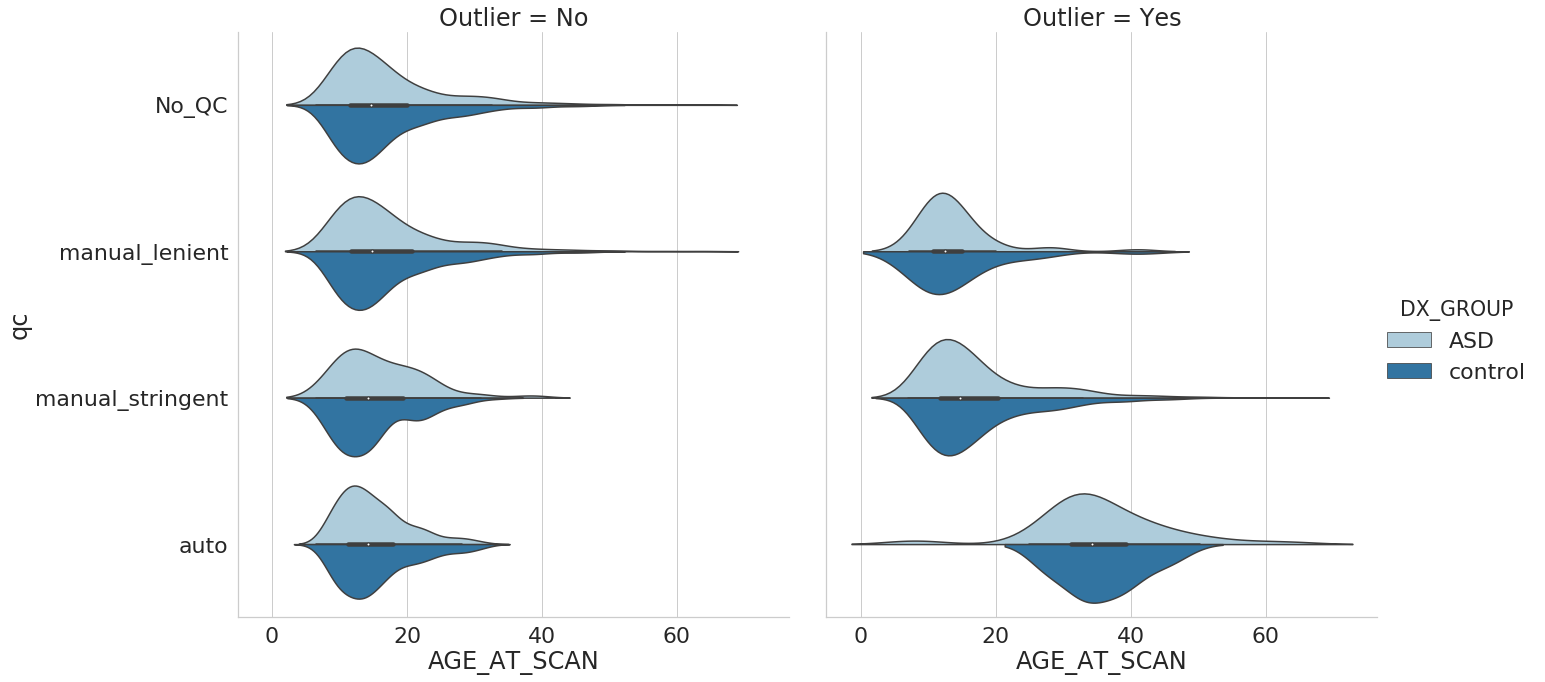

In [34]:
atlas = 'DKT'
demo_df_concat = pd.DataFrame()

for qc in qc_list:
    print('\nQC type: {}'.format(qc))
    parc_df = data_dict[atlas]     
    if qc == 'No_QC':        
        filtered_df = parc_df
        
    else:            
        if qc == 'manual_lenient':
            qc_df = pd.read_csv(qc_dir + 'master_QC_table.csv',dtype={'SubjID': int})
            qc_criterion = ('QC_maarten',[0]) # keep subs
        elif qc == 'manual_stringent':
            qc_df = pd.read_csv(qc_dir + 'master_QC_table.csv',dtype={'SubjID': int})
            qc_criterion = ('QC_gleb',['1','-+1']) # keep subs
        elif qc == 'auto':
            outlier_file = outlier_file_dict[atlas]
            qc_df = pd.read_csv(outlier_dir + outlier_file,dtype={'SubjID': int})
            qc_criterion = ('outlier_all_data',[0])    
        else:
            print('Unknow QC type')

        # Subjects you want to keep based on other crieria for sample size purposes
        external_criterion = None
        filtered_df = filter_data(parc_df, subject_ID_col, qc_df, qc_criterion, external_criterion)
    
    filtered_subs = filtered_df[subject_ID_col].unique()
    
    parc_df = pd.merge(parc_df,useful_demograph,on=subject_ID_col,how='left')
    parc_df['Outlier'] = np.tile('Yes',len(parc_df))
    parc_df.loc[parc_df[subject_ID_col].isin(filtered_subs),'Outlier'] = 'No'
    parc_df['qc'] = np.tile(qc,len(parc_df))
    demo_df_concat = demo_df_concat.append(parc_df[covar_list+['qc','Outlier']])
    
plot_df = demo_df_concat
plot_df['DX_GROUP'] = plot_df['DX_GROUP'].replace({0:'control', 1:'ASD'})
plot_df['SEX'] = plot_df['SEX'].replace({0:'M', 1:'F'})

sns.set(font_scale=2)

with sns.axes_style("whitegrid"):
    sns.catplot(x="AGE_AT_SCAN", y="qc", hue="DX_GROUP", kind="violin", split=True, height=10, aspect=1,
                col='Outlier',
                palette="Paired", data=plot_df);

### CCA between cortical "representations"
* Should be close to 1 since they are from same pipeline (FS6.0)

In [6]:
from sklearn.cross_decomposition import CCA

n_components = 10
possible_pairs = list(itertools.combinations(data_dict.keys(), 2))

sim_df_concat = pd.DataFrame()

for p, pair in enumerate(possible_pairs):
    print('\nAtlas pair {}'.format(pair))
    
    for qc in qc_list:
        print('\nQC type: {}'.format(qc))
        for a, atlas in enumerate(pair):
            parc_df = data_dict[atlas]
            
            if qc == 'No_QC':
                filtered_df = parc_df
                
            else:            
                if qc == 'manual_lenient':
                    qc_df = pd.read_csv(qc_dir + 'master_QC_table.csv',dtype={'SubjID': int})
                    qc_criterion = ('QC_maarten',[0]) # keep subs
                elif qc == 'manual_stringent':
                    qc_df = pd.read_csv(qc_dir + 'master_QC_table.csv',dtype={'SubjID': int})
                    qc_criterion = ('QC_gleb',['1','-+1']) # keep subs
                elif qc == 'auto':
                    outlier_file = outlier_file_dict[atlas]
                    qc_df = pd.read_csv(outlier_dir + outlier_file,dtype={'SubjID': int})
                    qc_criterion = ('outlier_all_data',[0])    
                else:
                    print('Unknow QC type')

                # Subjects you want to keep based on other crieria for sample size purposes
                external_criterion = None
                filtered_df = filter_data(parc_df, subject_ID_col, qc_df, qc_criterion, external_criterion)
            
            filtered_subs = filtered_df[subject_ID_col].unique()
            print('Resultant number of subjects {}'.format(len(filtered_subs)))
            roi_cols = filtered_df.filter(regex='^L|R_', axis=1).columns
            
            if a==0: 
                X = parc_df[roi_cols].values
            else:
                Y = parc_df[roi_cols].values
    
        print('representation shapes for qc {}, {}:{}, {}:{}'.format(qc, pair[0], X.shape, pair[1], Y.shape))            

        cca = CCA(n_components=n_components,scale=True)
        cca.fit(X, Y)
        X_c, Y_c = cca.transform(X, Y)
        corr_list = []
        for c in range(n_components):
            corr = np.corrcoef(X_c[:,c].flatten(),Y_c[:,c].flatten())[0,1]
            corr_list.append(np.round(corr,3))

        sim_df = pd.DataFrame(columns=['pair','cca_corr','qc_type'])
        sim_df.loc[p] = ['{}_{}'.format(pair[0],pair[1]),np.mean(corr_list),qc]

        sim_df_concat = sim_df_concat.append(sim_df)
        print('{} {} correlation {}'.format(parc1, parc2, np.mean(corr_list)))




Atlas pair ('aparc', 'Glasser')
No QC applied
Resultant number of subjects 1047
No QC applied
Resultant number of subjects 1047
representation shapes for qc No_QC, aparc:(1047, 68), Glasser:(1047, 360)


/home/nikhil/anaconda3/envs/CT_reproduce/lib/python3.5/site-packages/sklearn/cross_decomposition/pls_.py:79: ConvergenceWarning: Maximum number of iterations reached
  ConvergenceWarning)
/home/nikhil/anaconda3/envs/CT_reproduce/lib/python3.5/site-packages/sklearn/cross_decomposition/pls_.py:79: ConvergenceWarning: Maximum number of iterations reached
  ConvergenceWarning)
/home/nikhil/anaconda3/envs/CT_reproduce/lib/python3.5/site-packages/sklearn/cross_decomposition/pls_.py:79: ConvergenceWarning: Maximum number of iterations reached
  ConvergenceWarning)
/home/nikhil/anaconda3/envs/CT_reproduce/lib/python3.5/site-packages/sklearn/cross_decomposition/pls_.py:79: ConvergenceWarning: Maximum number of iterations reached
  ConvergenceWarning)
/home/nikhil/anaconda3/envs/CT_reproduce/lib/python3.5/site-packages/sklearn/cross_decomposition/pls_.py:79: ConvergenceWarning: Maximum number of iterations reached
  ConvergenceWarning)
/home/nikhil/anaconda3/envs/CT_reproduce/lib/python3.5/site-

NameError: name 'parc1' is not defined

In [ ]:
# Plot CCA transform correlations
plot_df = sim_df_concat
sns.set(font_scale=1)
with sns.axes_style("whitegrid"):
    g = sns.catplot(x='cca_corr',y='qc_type',hue='pair',palette='Set1',
                data=plot_df,aspect=2,height=5,kind='strip')

### Compare ML performance 

In [16]:
ml_results_dir = results_dir + 'ml/'
model_type = 'regression'
rank_features = False

ml_perf_concat = pd.DataFrame()

cv_type = 'shuffle_split'
feature_rank_df_concat = pd.DataFrame()

perf_pval_dict = {}
start_time_ML = time.time()

for atlas in data_dict.keys():
    start_time_atlas = time.time()
    print('\nAtlas {}'.format(atlas))
    master_df_raw = pd.merge(useful_demograph,data_dict[atlas],on= subject_ID_col)
    
    # For each atlas create a dictionary df
    for qc in qc_list:
        print('\nQC type: {}'.format(qc))
        if qc == 'No_QC':
            filtered_df = master_df_raw
            
        else:            
            if qc == 'manual_lenient':
                qc_df = pd.read_csv(qc_dir + 'master_QC_table.csv',dtype={'SubjID': int})
                qc_criterion = ('QC_maarten',[0]) # keep subs
            elif qc == 'manual_stringent':
                qc_df = pd.read_csv(qc_dir + 'master_QC_table.csv',dtype={'SubjID': int})
                qc_criterion = ('QC_gleb',['1','-+1']) # keep subs
            elif qc == 'auto':
                outlier_file = outlier_file_dict[atlas]
                qc_df = pd.read_csv(outlier_dir + outlier_file,dtype={'SubjID': int})
                qc_criterion = ('outlier_all_data',[0])    
            else:
                print('Unknow QC type')

            # Subjects you want to keep based on other crieria for sample size purposes
            external_criterion = {'SITE_ID':3*n_workflow}
            filtered_df = filter_data(master_df_raw, subject_ID_col, qc_df, qc_criterion, external_criterion)
        
        filtered_subs = filtered_df[subject_ID_col].unique()
        print('Resultant number of subjects {}'.format(len(filtered_subs)))
        
        master_df = filtered_df
        roi_cols = list(master_df.filter(regex='^L|R_', axis=1).columns)

        # Need to append Dx based performance separately for now
        # Since using scikit learn defined cross-val-score
        if model_type.lower() == 'regression':
            for dx_grp in [0,1]:
                print('Starting ML models for atlas {} qc {} dx {}'.format(atlas,qc,dx_grp))
                ml_master_df = master_df[master_df['DX_GROUP']==dx_grp]
                outcome_col = 'AGE_AT_SCAN'
                covar_continuous_cols = []
                covar_cat_cols = ['SEX','SITE_ID']
                
                model = RandomForestRegressor(max_depth=2, random_state=0, n_estimators=50)
                ml_perf, null_df, pvalue, feature_rank_df = getMLModelPerf(ml_master_df,roi_cols, 
                                                                           covar_continuous_cols,covar_cat_cols,
                                                                           outcome_col,model_type,model,
                                                                           rank_features,n_jobs=7)

                ml_perf['atlas'] = np.tile(atlas,len(ml_perf))
                ml_perf['qc'] = np.tile(qc,len(ml_perf))
                ml_perf['DX_GROUP'] = np.tile(dx_grp,len(ml_perf))
                
                null_df['atlas'] = np.tile('null',len(null_df))                
                null_df['qc'] = np.tile(qc,len(null_df))                
                null_df['DX_GROUP'] = np.tile(dx_grp,len(null_df))
                
                ml_perf_concat = ml_perf_concat.append(ml_perf).append(null_df)
                perf_pval_dict[atlas] = pvalue
                
                feature_rank_df['atlas'] = np.tile(atlas,len(feature_rank_df))
                feature_rank_df['DX_GROUP'] = np.tile(dx_grp,len(feature_rank_df))
                feature_rank_df['qc'] = np.tile(qc,len(feature_rank_df))            
                feature_rank_df_concat = feature_rank_df_concat.append(feature_rank_df)
        else: 
            print('Starting ML models for atlas {} qc {}'.format(atlas,qc))
            ml_master_df = master_df
            outcome_col = 'DX_GROUP'
            covar_continuous_cols = ['AGE_AT_SCAN']
            covar_cat_cols = ['SEX','SITE_ID']

            #model = svm.SVC(kernel='linear')
            model = RandomForestClassifier(n_estimators=50, max_depth=2,random_state=0)
            ml_perf, null_df, pvalue, feature_rank_df = getMLModelPerf(ml_master_df,roi_cols, covar_continuous_cols,covar_cat_cols,outcome_col,model_type,model)

            ml_perf['atlas'] = np.tile(atlas,len(ml_perf))
            null_df['atlas'] = np.tile('null',len(null_df))
            ml_perf['qc'] = np.tile(qc,len(ml_perf))
            null_df['qc'] = np.tile(qc,len(null_df))
            ml_perf['DX_GROUP'] = np.tile(dx_grp,len(ml_perf))
            null_df['DX_GROUP'] = np.tile(dx_grp,len(null_df))
            ml_perf_concat = ml_perf_concat.append(ml_perf).append(null_df)
            perf_pval_dict[atlas] = pvalue
            
            feature_rank_df['qc'] = np.tile(qc,len(feature_rank_df))            
            feature_rank_df_concat = feature_rank_df_concat.append(feature_rank_df)
            
    print('time to process atlas {:4.3f}m \n'.format((time.time()-start_time_atlas)/60.0))
print('time to process ML {:4.3}m'.format((time.time()-start_time_ML)/60.0))

# Save feature rank performance
ml_results_dir = results_dir + 'ml/'
save_path = '{}atlas_ml_feature_imp_{}_{}_cv_{}.pkl'.format(ml_results_dir,outcome_col,model_type,cv_type)
print('Saving sm_perf dictionary at \n{}'.format(save_path))
save_df = feature_rank_df_concat
save_df = save_df.rename(columns={'predictor':'roi'})
save_df.to_pickle(save_path)


Atlas DKT

QC type: No_QC
Resultant number of subjects 1047
Starting ML models for atlas DKT qc No_QC dx 0
Using ['SEX', 'SITE_ID'] categorical cols as 21 cat covar (dummies)
n of input columns: 84
Data shapes X (552, 84), y 552 (16.97m, 7.51sd)
Using regression model with perf metric neg_mean_squared_error
 Perf mean:-30.795, sd:9.641
Starting ML models for atlas DKT qc No_QC dx 1
Using ['SEX', 'SITE_ID'] categorical cols as 21 cat covar (dummies)
n of input columns: 84
Data shapes X (495, 84), y 495 (17.11m, 8.43sd)
Using regression model with perf metric neg_mean_squared_error
 Perf mean:-39.585, sd:14.418

QC type: manual_lenient

Filtering based on QC_maarten. Number subjects before filtering 1047
Resultant number of subjects 975
Filtering based on external crierion
Performing min sample (N_min=3) per workflow size check based on SITE_ID
Dropping subjects for all workflows for SITE_ID Series([], Name: SITE_ID, dtype: int64)
Resultant number of subjects 975
Resultant number of sub

 Perf mean:-30.534, sd:8.472
Starting ML models for atlas Destrieux qc manual_lenient dx 1
Using ['SEX', 'SITE_ID'] categorical cols as 21 cat covar (dummies)
n of input columns: 169
Data shapes X (450, 169), y 450 (17.42m, 8.58sd)
Using regression model with perf metric neg_mean_squared_error
 Perf mean:-41.657, sd:16.621

QC type: manual_stringent

Filtering based on QC_gleb. Number subjects before filtering 1047
Resultant number of subjects 240
Filtering based on external crierion
Performing min sample (N_min=3) per workflow size check based on SITE_ID
Dropping subjects for all workflows for SITE_ID UCLA_2     3
OHSU       3
MAX_MUN    3
PITT       2
Name: SITE_ID, dtype: int64
Resultant number of subjects 229
Resultant number of subjects 229
Starting ML models for atlas Destrieux qc manual_stringent dx 0
Using ['SEX', 'SITE_ID'] categorical cols as 11 cat covar (dummies)
n of input columns: 159
Data shapes X (132, 159), y 132 (14.99m, 5.52sd)
Using regression model with perf metric

{'DKT': 0.09090909090909091, 'Glasser': 0.09090909090909091, 'Destrieux': 0.09090909090909091}


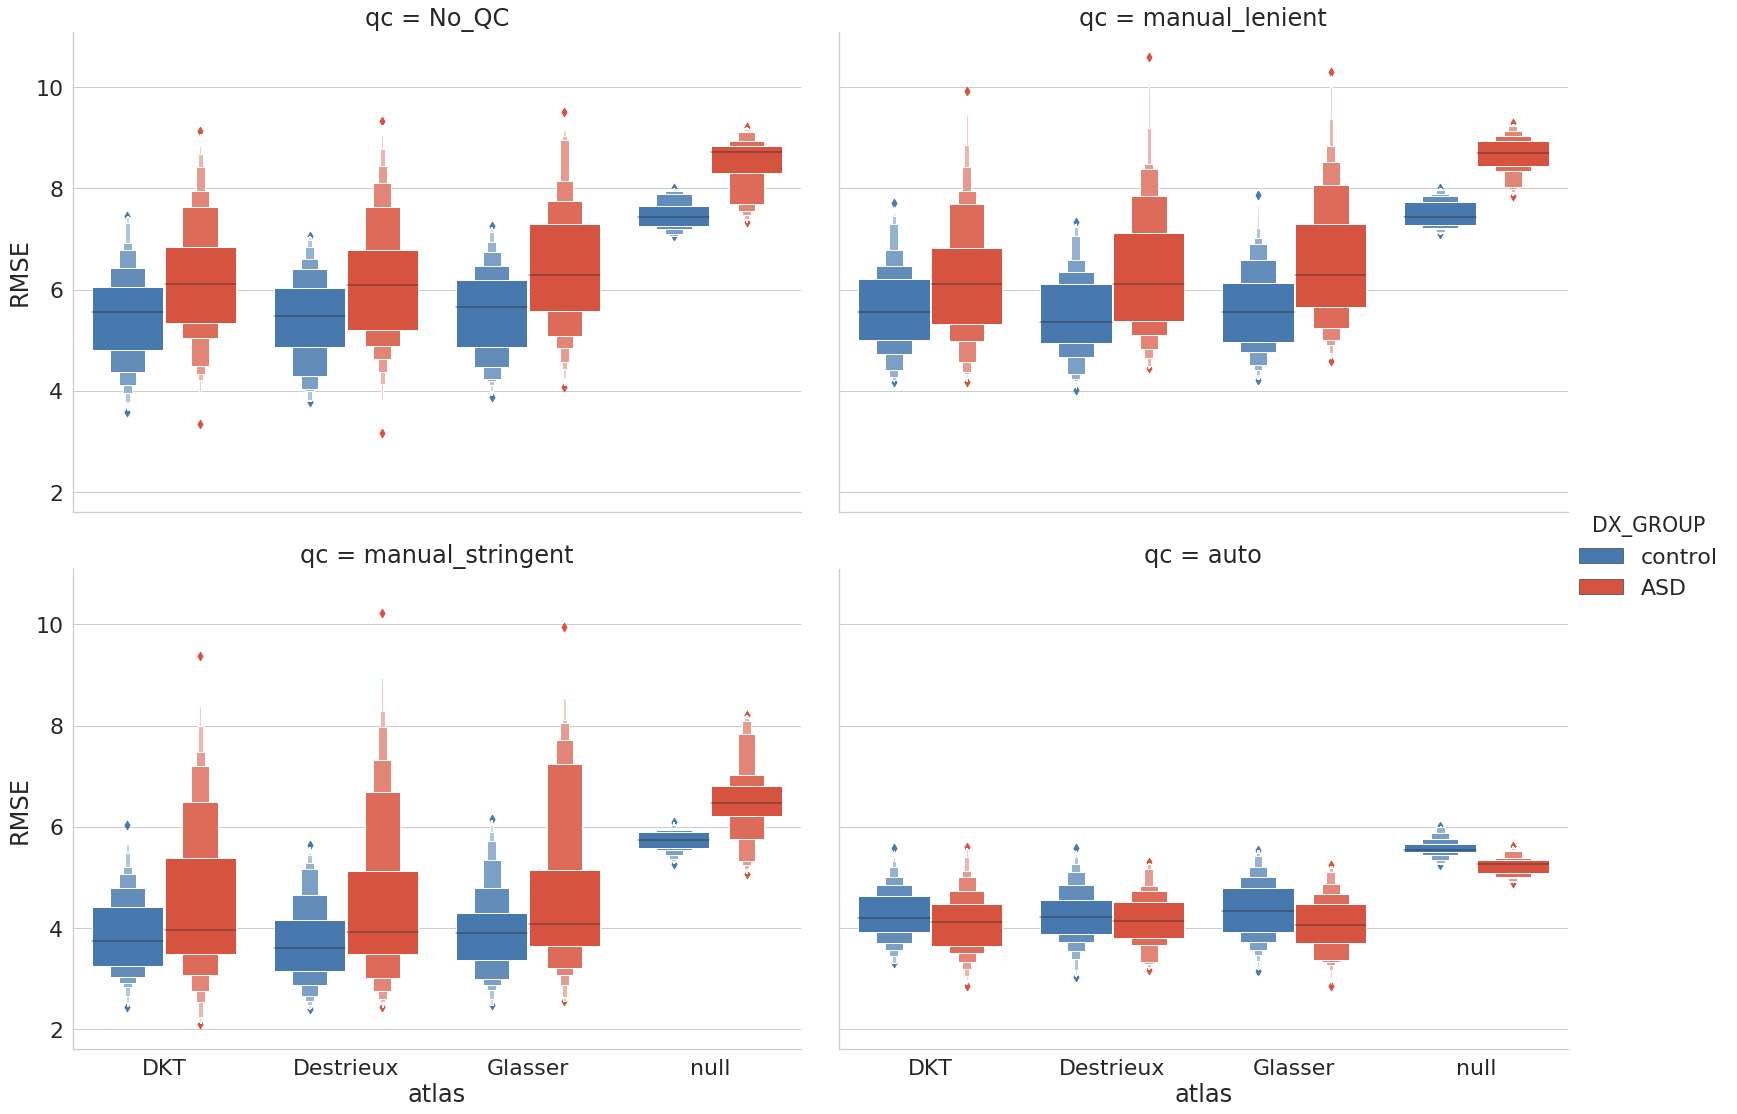

In [23]:
print(perf_pval_dict)
plot_df = ml_perf_concat.copy()
x_order = ['DKT','Destrieux','Glasser','null']
col_order = qc_list

colors = ["windows blue", "tomato", "greyish", "dark grey","faded green", "dusty purple"]
palette = sns.xkcd_palette(colors) #'Paired' #sns.xkcd_palette(colors)

sns.set(font_scale=5)

if model_type.lower() == 'regression':
    plot_df['RMSE'] = np.sqrt(-1*plot_df['neg_mean_squared_error'])
    plot_df['DX_GROUP'] = plot_df['DX_GROUP'].replace({0:'control', 1:'ASD'})
    
    sns.set(font_scale=2)
    with sns.axes_style("whitegrid"): 
        
        g = sns.catplot(y='RMSE',x='atlas',kind='boxen',hue='DX_GROUP', col='qc',col_order=col_order,col_wrap=2, 
                        data=plot_df, legend=True,
                        order=x_order, palette=palette, height=8, aspect=1.4 )
        #plt.legend(loc='upper right')
else:
    with sns.axes_style("white"): 
        g = sns.catplot(y='roc_auc',x='atlas', kind='boxen',data=plot_df,col='qc',col_order=col_order,
                        order=x_order,palette=palette,height=20, aspect=1.1,legend=False)    

### Get ML based feature importance

In [52]:
# save_path = '{}atlas_ml_feature_imp_{}_{}.pkl'.format(ml_results_dir,outcome_col,model_type)
# feature_rank_df_concat = pd.read_pickle(save_path)

feature_count_df = pd.DataFrame(columns=['count','atlas','DX_GROUP','qc'])
i = 0
for atlas in data_dict.keys():
    master_df_raw = pd.merge(useful_demograph,data_dict[atlas],on= subject_ID_col)
    roi_cols = list(master_df_raw.filter(regex='^L|R_', axis=1).columns)
    for qc in feature_rank_df_concat['qc'].unique():
        for dx in [0,1]:
            n_feat = len(feature_rank_df_concat[(feature_rank_df_concat['rank'] == 1) &                              
                                                (feature_rank_df_concat['atlas'] == atlas) &                              
                                                (feature_rank_df_concat['predictor'].isin(roi_cols)) & 
                                                (feature_rank_df_concat['qc'] == qc) &
                                                (feature_rank_df_concat['DX_GROUP'] == dx)])
            feature_count_df.loc[i] = [n_feat,atlas,dx,qc]
            i+=1
            print('atlas {}, n_roi {}, qc {}, dx {}, n_feat {}\n'.format(atlas,len(roi_cols),qc,dx,n_feat))

atlas Glasser, n_roi 360, qc No_QC, dx 0, n_feat 30

atlas Glasser, n_roi 360, qc No_QC, dx 1, n_feat 22

atlas Glasser, n_roi 360, qc manual_maarten, dx 0, n_feat 41

atlas Glasser, n_roi 360, qc manual_maarten, dx 1, n_feat 42

atlas Glasser, n_roi 360, qc manual_gleb, dx 0, n_feat 248

atlas Glasser, n_roi 360, qc manual_gleb, dx 1, n_feat 294

atlas Glasser, n_roi 360, qc auto, dx 0, n_feat 23

atlas Glasser, n_roi 360, qc auto, dx 1, n_feat 21

atlas aparc, n_roi 68, qc No_QC, dx 0, n_feat 18

atlas aparc, n_roi 68, qc No_QC, dx 1, n_feat 65

atlas aparc, n_roi 68, qc manual_maarten, dx 0, n_feat 57

atlas aparc, n_roi 68, qc manual_maarten, dx 1, n_feat 35

atlas aparc, n_roi 68, qc manual_gleb, dx 0, n_feat 27

atlas aparc, n_roi 68, qc manual_gleb, dx 1, n_feat 25

atlas aparc, n_roi 68, qc auto, dx 0, n_feat 26

atlas aparc, n_roi 68, qc auto, dx 1, n_feat 19

atlas Destrieux, n_roi 148, qc No_QC, dx 0, n_feat 19

atlas Destrieux, n_roi 148, qc No_QC, dx 1, n_feat 22

atlas De

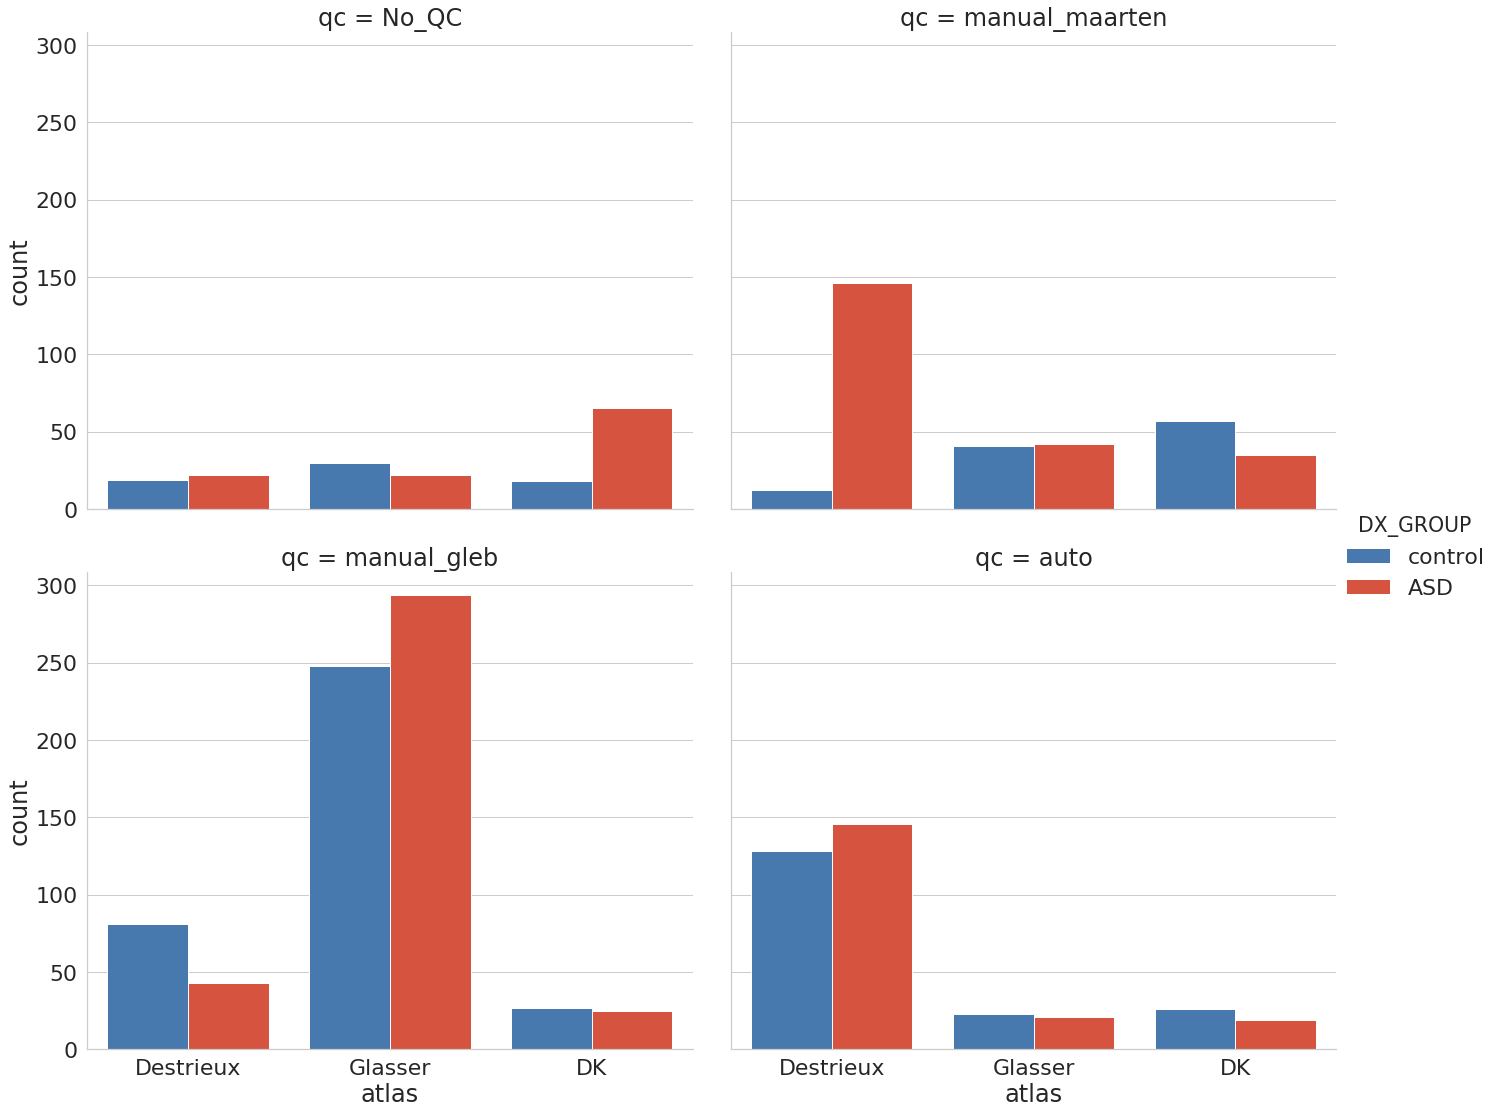

In [55]:
plot_df = feature_count_df #[feature_count_df['qc']=='No_QC']
plot_df['atlas'] = plot_df['atlas'].replace({'aparc':'DK'})
plot_df['DX_GROUP'] = plot_df['DX_GROUP'].replace({0:'control', 1:'ASD'})
sns.set(font_scale=2)

with sns.axes_style("whitegrid"): 
    x_order = ['Destrieux','Glasser','DK']
    g = sns.catplot(y='count',x='atlas',hue='DX_GROUP', col='qc', col_wrap=2,
                    kind='bar', palette=palette, height=8, aspect=1.2, data=plot_df, order=x_order)


### Compare statsmodels performance 

In [27]:
qc_list

['No_QC', 'manual_maarten', 'manual_gleb', 'auto']

In [29]:
sm_results_dir = results_dir + 'sm/'
model_type = 'ols'
if model_type == 'ols':
    covar_cols = [('DX_GROUP','cat'),('SEX','cat'),('SITE_ID','cat')]
    outcome_col = ('roi','continuous')
    signific_col = ('AGE_AT_SCAN','continuous')
    stat_model = 'ols' 
elif model_type == 'logit':
    covar_cols = [('AGE_AT_SCAN','continuous'),('SEX','cat'),('SITE_ID','cat')]
    outcome_col = ('DX_GROUP','cat') 
    signific_col = ('roi','continuous') 
    stat_model = 'logit' 
else:
    print('unknown stat model')
    
save_sm_perf = True
n_workflow = 1 #Analyzing each atlas separately

outlier_df = pd.DataFrame(index=useful_demograph[subject_ID_col].unique())
for qc in qc_list:
    # For each atlas create a dictionary df
    stat_perf_dict = {}
    for atlas in data_dict.keys():
        start_time_atlas = time.time()
        print('\nAtlas {}'.format(atlas))
        
        mr_data_df = data_dict[atlas]
        roi_cols = list(mr_data_df.filter(regex='^L|R_', axis=1).columns)
        master_df_raw = pd.merge(useful_demograph,mr_data_df[[subject_ID_col]+ roi_cols],on=subject_ID_col)

        if qc == 'No_QC':
            print('No QC applied')
            filtered_df = master_df_raw
            filtered_subs = filtered_df[subject_ID_col].unique()
            print('Resultant number of subjects {}'.format(len(filtered_subs)))
        else:            
            if qc == 'manual_lenient':
                qc_df = pd.read_csv(qc_dir + 'master_QC_table.csv',dtype={'SubjID': int})
                qc_criterion = ('QC_maarten',[0]) # keep subs
            elif qc == 'manual_stringent':
                qc_df = pd.read_csv(qc_dir + 'master_QC_table.csv',dtype={'SubjID': int})
                qc_criterion = ('QC_gleb',['1','-+1']) # keep subs
            elif qc == 'auto':
                outlier_file = outlier_file_dict[atlas]
                qc_df = pd.read_csv(outlier_dir + outlier_file,dtype={'SubjID': int})
                qc_criterion = ('outlier_all_data',[0])    
            else:
                print('Unknow QC type')

            # Subjects you want to keep based on other crieria for sample size purposes
            external_criterion = {'SITE_ID':4*n_workflow}
            filtered_df = filter_data(master_df_raw, subject_ID_col, qc_df, qc_criterion, external_criterion)
            filtered_subs = filtered_df[subject_ID_col].unique()

        master_df = filtered_df
        master_df['atlas'] = np.tile(atlas,len(master_df))
        sm_perf = getStatModelPerf(master_df,roi_cols,covar_cols,outcome_col,signific_col,stat_model)
        
        print('Shape of the stats_models results df {}'.format(sm_perf.shape))
        print('Top 5 significant regions:\n {}'.format(sm_perf.sort_values(by=['p_val']).head(5)))
        print('')
        stat_perf_dict[atlas] = sm_perf
        
    #only need to do it for one atlas (since manual outliers are same for all atlases)
    if qc != 'No_QC':
        outlier_df[qc] = np.where(outlier_df.index.isin(filtered_subs),0,1)
        
    if save_sm_perf:
        save_path = '{}Atlas_FS6.0_sm_perf_{}_{}_{}_QC_{}_N_{}.pkl'.format(sm_results_dir,outcome_col[0],signific_col[0],stat_model,qc,len(filtered_subs))
        print('Saving sm_perf dictionary at \n{}'.format(save_path))
        with open(save_path, 'wb') as handle:
            pickle.dump(stat_perf_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)



Atlas DKT
No QC applied
Resultant number of subjects 1047
Example statsmodel run:
 R_temporalpole ~ AGE_AT_SCAN + C(DX_GROUP) + C(SEX) + C(SITE_ID)
Shape of the stats_models results df (63, 5)
Top 5 significant regions:
                    roi      coef      t_val         p_val    p_val_corr
53         R_precuneus -0.013659 -20.306166  2.657336e-77  1.674121e-75
22         L_precuneus -0.013331 -18.655814  4.317231e-67  1.359928e-65
5   L_inferiorparietal -0.013289 -18.376888  2.091349e-65  4.391832e-64
57  R_superiorparietal -0.012485 -17.373256  1.889824e-59  2.976472e-58
56   R_superiorfrontal -0.013625 -17.282259  6.422322e-59  8.092126e-58


Atlas Glasser
No QC applied
Resultant number of subjects 1047
Example statsmodel run:
 R_p24_ROI ~ AGE_AT_SCAN + C(DX_GROUP) + C(SEX) + C(SITE_ID)
Shape of the stats_models results df (360, 5)
Top 5 significant regions:
              roi      coef      t_val         p_val    p_val_corr
85   L_9_46d_ROI -0.013893 -14.914429  1.144941e-45  4.12

Example statsmodel run:
 R_temporalpole ~ AGE_AT_SCAN + C(DX_GROUP) + C(SEX) + C(SITE_ID)
Shape of the stats_models results df (63, 5)
Top 5 significant regions:
                    roi      coef      t_val         p_val    p_val_corr
53         R_precuneus -0.017797 -18.967334  3.880463e-68  2.444692e-66
5   L_inferiorparietal -0.018895 -18.802779  3.705581e-67  1.167258e-65
57  R_superiorparietal -0.018502 -18.415474  7.247198e-65  1.521912e-63
22         L_precuneus -0.018342 -18.267593  5.360984e-64  8.443550e-63
26  L_superiorparietal -0.017481 -17.487713  1.805966e-59  2.275517e-58


Atlas Glasser

Filtering based on outlier_all_data. Number subjects before filtering 1047
Resultant number of subjects 963
Filtering based on external crierion
Performing min sample (N_min=4) per workflow size check based on SITE_ID
Dropping subjects for all workflows for SITE_ID SBL    4
Name: SITE_ID, dtype: int64
Resultant number of subjects 959
Example statsmodel run:
 R_p24_ROI ~ AGE_AT_SCAN + C

Total number of subjects: 1112

outlier overlap
                manual_maarten  manual_gleb  auto
manual_maarten             137          135    72
manual_gleb                135          887   147
auto                        72          147   154


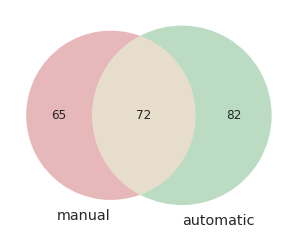

In [76]:
# Outlier comparisons
outlier_overlap = outlier_df.T.dot(outlier_df)
print('Total number of subjects: {}\n'.format(len(outlier_df)))
print('outlier overlap')
print(outlier_overlap)

# Venn diagrams
s1 = set(outlier_df[outlier_df['manual_maarten']==1].index)
s2 = set(outlier_df[outlier_df['manual_gleb']==1].index)
s3 = set(outlier_df[outlier_df['auto']==1].index)
v = venn2([s1,s3],set_labels = ('manual', 'automatic'))
#venn3([s1,s2,s3],set_labels = ('manual_maarten', 'manual_gleb', 'auto'))


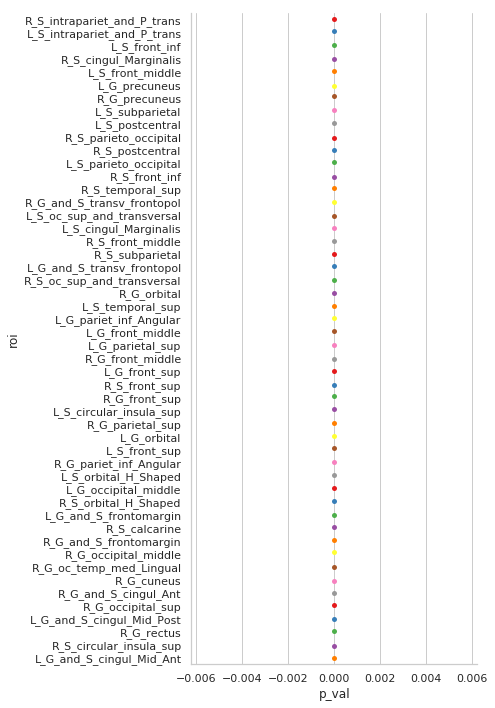

In [25]:
# Plots
aparc = 'Destrieux' #'Destrieux', 'aparc','Glasser'
top_rois = 50
plot_df = stat_perf_dict[aparc].sort_values(by=['p_val']).head(top_rois)

sns.set(font_scale=1)
with sns.axes_style("whitegrid"):
    g = sns.catplot(x='p_val',y='roi',kind='strip',
                    data=plot_df,palette='Set1',height=10,aspect=0.7)
    #g.set(xscale="log");